### Dependecies

In [ ]:
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [1]:
!pip install chart_studio
!pip install statsmodels --upgrade

     |████████████████████████████████| 64 kB 1.6 MB/s 
     |████████████████████████████████| 9.8 MB 5.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import chart_studio.plotly as py
import plotly.express as px
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import statsmodels.api as sm
from pylab import rcParams

### Loading the Data

In [3]:
covid = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')

countries = covid.location.unique()
indexer = covid[covid.location == 'Ireland'].index
countries = covid.loc[indexer, 'date': 'new_deaths_per_million']
countries = countries.dropna()
countries.set_index('date', inplace=True)
countries.drop(countries.columns.difference(['new_deaths_per_million']), axis=1, inplace=True)
countries['MA30'] = countries.rolling(window=30).mean()['new_deaths_per_million']
countries = countries.asfreq('d')

In [4]:
fig = px.line(countries, countries.index, 'new_deaths_per_million', labels={'x':'Date'})
fig.add_scatter(x=countries.index, y=countries.MA30, name='Moving Average')

### Train Test Split

In [5]:
train_df = countries.iloc[:427]
test_df = countries.iloc[427:]

### Creating the Model

#### Forecasting the Death Rate for the next 180 days

In [ ]:
model = ExponentialSmoothing(train_df['new_deaths_per_million'],
                             trend='add', seasonal='add',
                             seasonal_periods=56).fit()

predict = model.forecast(100)

#### plotting the Prediction Result

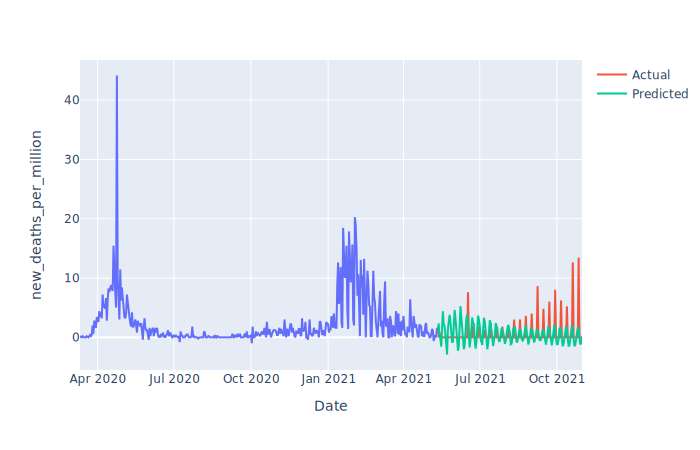

In [13]:
ar_model = AutoReg(train_df['new_deaths_per_million'], 120, trend='n').fit(cov_type='HC0')
start = len(train_df)
stop = len(train_df) + len(test_df) -1

predict = ar_model.predict(start=start, end=stop, dynamic=True)
fig = px.line(train_df, train_df.index, 'new_deaths_per_million', labels={'x':'Date'})
fig.add_scatter(x=test_df.index, y=test_df.new_deaths_per_million, name='Actual')
fig.add_scatter(x=predict.index, y=predict, name='Predicted')
fig.show('svg')

### Checking for Trend or Seasonality

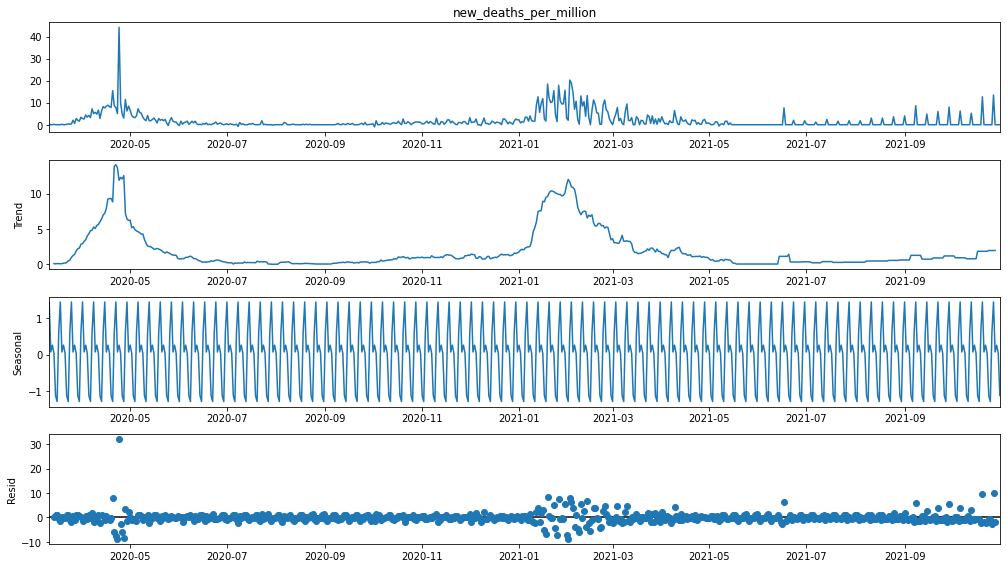

In [16]:
rcParams['figure.figsize'] = 14, 8
decomp_series = sm.tsa.seasonal_decompose(countries.new_deaths_per_million, model='addictive')
decomp_series.plot()
plt.show()